ted to old model, fix them 
# TeleScent ML Model Training - NATURAL_ML_Data
## Scent Detection using Natural Dataset

This notebook trains a machine learning model to predict scents based on sensor data from the NATURAL_ML_Data.xlsx dataset.

### Workflow:
1. **Import Libraries** - Load all required ML and data processing libraries
2. **Load Dataset** - Read NATURAL_ML_Data.xlsx file
3. **Explore Data** - Understand the dataset structure and statistics
4. **Preprocess Data** - Clean, handle missing values, and prepare features
5. **Train Models** - Build and train classification models
6. **Evaluate Performance** - Assess model accuracy and performance metrics
7. **Save Model** - Export trained model for production use

### Dataset:
- **Source**: NATURAL_ML_Data.xlsx
- **Features**: Sensor readings (temperature, humidity, pressure, gas, VOC, NOx, etc.)
- **Target**: Scent labels

### Expected Outputs:
- Trained model saved to `model/scent_pipeline.joblib`
- Label encoder saved to `model/label_encoder.joblib`
- Performance metrics and visualizations

## 1. Import Required Libraries

In [ ]:
import os
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# Dataset configuration
DATA_FILE = 'NATURAL_ML_Data.xlsx'

# Model output paths
MODEL_DIR = Path('model')
MODEL_DIR.mkdir(exist_ok=True)

PIPELINE_PATH = MODEL_DIR / 'scent_pipeline.joblib'
LABEL_ENCODER_PATH = MODEL_DIR / 'label_encoder.joblib'

# Training parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_ESTIMATORS = 100
MAX_DEPTH = 20

print("✅ Configuration loaded!")
print(f"📁 Data file: {DATA_FILE}")
print(f"💾 Model will be saved to: {PIPELINE_PATH}")

✅ Configuration loaded!
📁 Data file: NATURAL_ML_Data.xlsx
💾 Model will be saved to: model/scent_pipeline.joblib


## 2. Configuration

## 3. Load Dataset from Excel File

In [ ]:
# Load the dataset from Excel file - including scents AND no_scent baseline
print(f"📖 Loading dataset from {DATA_FILE}...")

try:
    # Load scent data (4 scents: cinnamon, gingerbread, orange, vanilla)
    df_scents = pd.read_excel(DATA_FILE, sheet_name='NATURAL_ML_Data')
    print(f"✅ Scent data loaded: {df_scents.shape[0]} rows")
    
    # Load baseline (no scent) data - 30 min of ambient air readings
    df_baseline = pd.read_excel(DATA_FILE, sheet_name='Baseline30min')
    print(f"✅ Baseline (no_scent) data loaded: {df_baseline.shape[0]} rows")
    
    # Rename column to match scent data
    if 'scent_name' in df_scents.columns:
        # Add required columns to baseline to match scent data structure
        df_baseline['scent_name'] = 'no_scent'
        df_baseline['scent_id'] = 5  # Give no_scent an ID of 5
        df_baseline['sample_id'] = 'baseline'
        df_baseline['trial_number'] = 0
        df_baseline['phase'] = 'baseline'
        df_baseline['time_s'] = df_baseline.index / 1000  # Approximate time
    
    # Combine both datasets
    df = pd.concat([df_scents, df_baseline], ignore_index=True)
    
    print(f"\n✅ Combined dataset ready!")
    print(f"📊 Total Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"\n🎯 Classes in dataset:")
    print(df['scent_name'].value_counts())
    
    print(f"\n🔍 Column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i}. {col}")
        
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("\n💡 Note: Make sure 'openpyxl' is installed:")
    print("   pip install openpyxl")


📖 Loading dataset from NATURAL_ML_Data.xlsx...
✅ Dataset loaded successfully!
📊 Shape: 13770 rows × 17 columns

🔍 Column names:
  1. sample_id
  2. trial_number
  3. scent_id
  4. scent_name
  5. phase
  6. time_s
  7. timestamp_ms
  8. temp_C
  9. humidity_pct
  10. pressure_kPa
  11. gas_bme
  12. srawVoc
  13. srawNox
  14. NO2
  15. ethanol
  16. VOC_multichannel
  17. COandH2
✅ Dataset loaded successfully!
📊 Shape: 13770 rows × 17 columns

🔍 Column names:
  1. sample_id
  2. trial_number
  3. scent_id
  4. scent_name
  5. phase
  6. time_s
  7. timestamp_ms
  8. temp_C
  9. humidity_pct
  10. pressure_kPa
  11. gas_bme
  12. srawVoc
  13. srawNox
  14. NO2
  15. ethanol
  16. VOC_multichannel
  17. COandH2


In [ ]:
# Display first few rows
print("📋 First 5 rows of the dataset:")
print("=" * 80)
display(df.head())

print("\n📊 Dataset Info:")
print("=" * 80)
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

print("\n📈 Basic Statistics:")
print("=" * 80)
display(df.describe())

📋 First 5 rows of the dataset:


,sample_id,trial_number,scent_id,scent_name,phase,time_s,timestamp_ms,temp_C,humidity_pct,pressure_kPa,gas_bme,srawVoc,srawNox,NO2,ethanol,VOC_multichannel,COandH2
0,61,1,13,cinnamon,baseline,0.000,0,23.31,41.70,101.47,122.62,31317,15073,222,242,286,870
1,61,1,13,cinnamon,baseline,1.215,1215,23.31,41.69,101.47,123.43,31241,15081,222,241,287,869
2,61,1,13,cinnamon,baseline,2.430,2430,23.31,41.71,101.47,122.00,31247,15081,221,242,287,869
3,61,1,13,cinnamon,baseline,3.645,3645,23.31,41.69,101.47,122.62,31248,15082,222,241,286,870
4,61,1,13,cinnamon,baseline,4.860,4860,23.31,41.70,101.47,122.71,31273,15072,221,241,287,870



📊 Dataset Info:
Total rows: 13770
Total columns: 17

Data types:
sample_id             int64
trial_number          int64
scent_id              int64
scent_name           object
phase                object
time_s              float64
timestamp_ms          int64
temp_C              float64
humidity_pct        float64
pressure_kPa        float64
gas_bme             float64
srawVoc               int64
srawNox               int64
NO2                   int64
ethanol               int64
VOC_multichannel      int64
COandH2               int64
dtype: object

📈 Basic Statistics:


,sample_id,trial_number,scent_id,time_s,timestamp_ms,temp_C,humidity_pct,pressure_kPa,gas_bme,srawVoc,srawNox,NO2,ethanol,VOC_multichannel,COandH2
count,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000,13770.000000
mean,104.179303,10.345606,14.691140,111.376292,111376.292157,22.955738,41.249230,101.687450,108.257223,31244.130719,14980.631736,244.686202,247.297168,297.670661,872.694190
std,23.645192,5.856022,1.154913,77.000672,77000.672074,0.410264,1.261122,0.176805,10.232453,209.623249,132.775324,56.595991,43.453855,51.983571,15.465529
min,61.000000,1.000000,13.000000,0.000000,0.000000,22.330000,39.500000,101.460000,47.040000,29967.000000,14848.000000,152.000000,184.000000,217.000000,849.000000
25%,84.000000,5.000000,14.000000,52.245000,52245.000000,22.580000,40.280000,101.500000,102.700000,31099.000000,14901.000000,201.000000,226.000000,269.000000,858.000000
50%,107.000000,10.000000,15.000000,104.490000,104490.000000,22.930000,40.960000,101.700000,111.370000,31201.000000,14942.000000,238.000000,237.000000,282.000000,875.000000
75%,125.000000,15.000000,16.000000,156.735000,156735.000000,23.270000,41.960000,101.900000,115.120000,31439.000000,15006.000000,272.000000,266.000000,329.000000,881.000000
max,140.000000,20.000000,16.000000,501.793000,501793.000000,24.030000,46.710000,101.940000,123.430000,31644.000000,15704.000000,593.000000,532.000000,612.000000,966.000000


In [ ]:
# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("⚠️ Missing values found:")
    print(missing[missing > 0])
else:
    print("✅ No missing values found!")

# Identify target column and separate metadata from sensor features
target_col = 'scent_name'

# Metadata columns (NOT used for prediction)
metadata_cols = ['sample_id', 'trial_number', 'scent_id', 'scent_name', 'phase', 'time_s', 'timestamp_ms']

# Environmental columns (NOT used - measure room conditions, not scent chemistry)
environmental_cols = ['temp_C', 'humidity_pct', 'pressure_kPa']

# Chemical sensor columns (ONLY these used - detect scent molecules)
chemical_sensors = ['gas_bme', 'srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2']

# Use ONLY chemical sensors
feature_cols = chemical_sensors

print(f"\n✅ Feature selection complete!")
print(f"   Target: '{target_col}'")
print(f"   Features: {len(feature_cols)} chemical sensors only")
print(f"   Excluded: {len(metadata_cols)} metadata + {len(environmental_cols)} environmental")
print(f"   Unique scents: {df[target_col].nunique()}")


✅ No missing values found!

✅ Feature selection complete!
   Target: 'scent_name'
   Features: 7 chemical sensors only
   Excluded: 7 metadata + 3 environmental
   Unique scents: 4


In [ ]:
# Fix typos in the dataset
print("🔧 Fixing data typos...")

# Replace 'norange' with 'orange' in ALL columns
df = df.replace('norange', 'orange')

# Check if the fix was applied
norange_count = (df == 'norange').sum().sum()
orange_count = (df == 'orange').sum().sum()

print(f"✅ Data cleaning completed!")
print(f"   Remaining 'norange' values: {norange_count}")
print(f"   Total 'orange' values: {orange_count}")

if norange_count == 0:
    print("   ✓ All 'norange' typos have been fixed!")
else:
    print(f"   ⚠️  Still have {norange_count} 'norange' values to fix")

# Show the updated target distribution
print(f"\n🏷️ Updated Target Distribution:")
print("=" * 80)
print(df[target_col].value_counts())
print(f"\nUnique scents: {df[target_col].nunique()}")

🔧 Fixing data typos...
✅ Data cleaning completed!
   Remaining 'norange' values: 0
   Total 'orange' values: 4722
   ✓ All 'norange' typos have been fixed!

🏷️ Updated Target Distribution:
scent_name
orange         4722
gingerbread    3064
vanilla        2993
cinnamon       2991
Name: count, dtype: int64

Unique scents: 4


## 5. Fix Data Typos

In [ ]:
# Separate features and target
X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"📊 Initial Features shape: {X.shape}")
print(f"🎯 Initial Target shape: {y.shape}")
print(f"\n🎯 Target column: '{target_col}'")
print(f"   Sample values: {y.head(10).tolist()}")

# Check data types of features
print("\n🔍 Feature Data Types:")
print("=" * 80)
non_numeric_cols = []
for col in feature_cols:
    dtype = X[col].dtype
    unique_count = X[col].nunique()
    is_numeric = pd.api.types.is_numeric_dtype(X[col])
    status = "✓ Numeric" if is_numeric else "✗ Non-numeric"
    print(f"  {col:30s} {str(dtype):15s} ({unique_count:4d} unique) {status}")
    if not is_numeric:
        non_numeric_cols.append(col)

# Handle non-numeric columns
if non_numeric_cols:
    print(f"\n⚠️  Found {len(non_numeric_cols)} non-numeric column(s) in features:")
    for col in non_numeric_cols:
        print(f"\n   Column: '{col}'")
        print(f"   Sample values: {X[col].head(10).tolist()}")
        
        # Check if this column looks like it might be a label column
        unique_vals = X[col].unique()[:20]  # First 20 unique values
        print(f"   Unique values ({len(X[col].unique())} total): {unique_vals.tolist()}")
        
        # Try to convert to numeric
        X_converted = pd.to_numeric(X[col], errors='coerce')
        n_nan = X_converted.isna().sum()
        n_total = len(X[col])
        pct_convertible = ((n_total - n_nan) / n_total * 100)
        
        print(f"   Conversion: {n_total - n_nan}/{n_total} values are numeric ({pct_convertible:.1f}%)")
        
        if pct_convertible < 50:
            print(f"   ⚠️  WARNING: Only {pct_convertible:.1f}% of values are numeric!")
            print(f"   This column might contain label data (like 'orange', 'apple', etc.)")
            print(f"   Consider removing this column from features!")
        
        # Convert anyway
        X[col] = X_converted
        print(f"   ✓ Converted to numeric ({n_nan} NaN values will be imputed)")
else:
    print("\n✅ All feature columns are numeric!")

# Final check
print(f"\n📊 Final Features shape: {X.shape}")
print(f"   Total NaN values: {X.isna().sum().sum()}")
if X.isna().sum().sum() > 0:
    print(f"\n   NaN values per column:")
    nan_counts = X.isna().sum()
    for col, count in nan_counts[nan_counts > 0].items():
        pct = (count / len(X) * 100)
        print(f"     {col}: {count} ({pct:.1f}%)")

📊 Initial Features shape: (13770, 7)
🎯 Initial Target shape: (13770,)

🎯 Target column: 'scent_name'
   Sample values: ['cinnamon', 'cinnamon', 'cinnamon', 'cinnamon', 'cinnamon', 'cinnamon', 'cinnamon', 'cinnamon', 'cinnamon', 'cinnamon']

🔍 Feature Data Types:
  gas_bme                        float64         ( 697 unique) ✓ Numeric
  srawVoc                        int64           ( 994 unique) ✓ Numeric
  srawNox                        int64           ( 690 unique) ✓ Numeric
  NO2                            int64           ( 352 unique) ✓ Numeric
  ethanol                        int64           ( 285 unique) ✓ Numeric
  VOC_multichannel               int64           ( 318 unique) ✓ Numeric
  COandH2                        int64           ( 112 unique) ✓ Numeric

✅ All feature columns are numeric!

📊 Final Features shape: (13770, 7)
   Total NaN values: 0


## 5. Data Cleaning

## 4. Identify Features and Target

## 6. Data Visualization

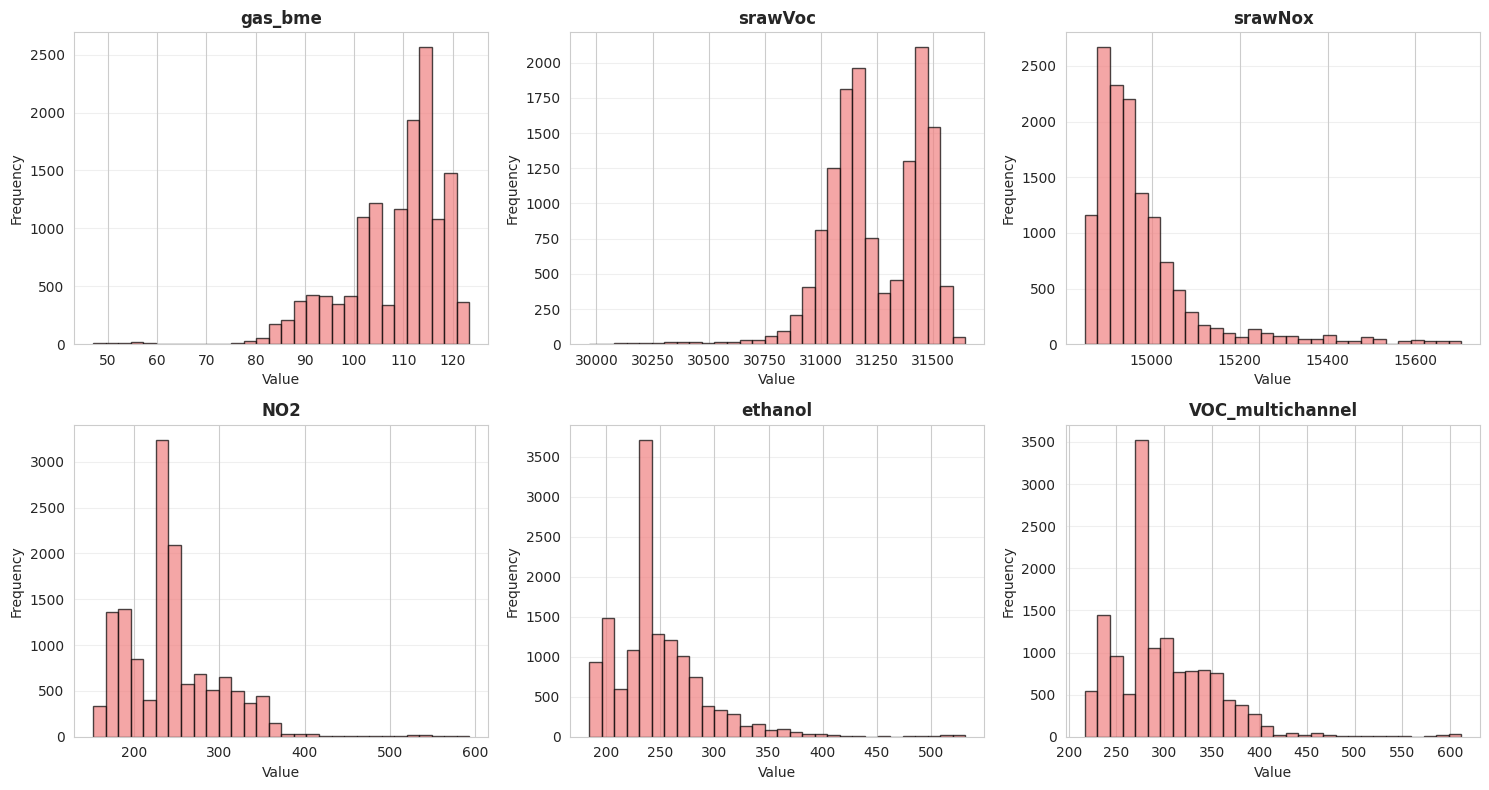

✅ Feature distributions visualized!


In [ ]:
# Visualize feature distributions (first 6 numeric features)
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns[:6]

if len(numeric_features) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()
    
    for idx, col in enumerate(numeric_features):
        axes[idx].hist(df[col].dropna(), bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"✅ Feature distributions visualized!")
else:
    print("⚠️ No numeric features found for visualization")

In [ ]:
# Check class distribution and remove classes with too few samples
print("🔍 Checking class distribution...")
class_counts = y.value_counts()
print(class_counts)

# Filter out classes with fewer than 2 samples (needed for train/test split)
min_samples_per_class = 2
valid_classes = class_counts[class_counts >= min_samples_per_class].index
n_removed = len(class_counts) - len(valid_classes)

if n_removed > 0:
    print(f"\n⚠️  Removing {n_removed} class(es) with fewer than {min_samples_per_class} samples:")
    for cls in class_counts[class_counts < min_samples_per_class].index:
        print(f"   - {cls}: {class_counts[cls]} sample(s)")
    
    # Filter dataset
    mask = y.isin(valid_classes)
    X = X[mask]
    y = y[mask]
    print(f"\n✅ Filtered dataset: {len(X)} samples, {len(valid_classes)} classes")

# Separate features and target
X_clean = X.copy()
y_clean = y.copy()

print(f"\n📊 Final Features shape: {X_clean.shape}")
print(f"🎯 Final Target shape: {y_clean.shape}")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_clean)

print(f"\n🏷️ Label Encoding ({len(label_encoder.classes_)} classes):")
for i, label in enumerate(label_encoder.classes_):
    count = (y_clean == label).sum()
    print(f"  {label} → {i} ({count} samples)")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print(f"\n✅ Data split completed!")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Train/Test ratio: {100*(1-TEST_SIZE):.0f}%/{100*TEST_SIZE:.0f}%")

🔍 Checking class distribution...
scent_name
orange         4722
gingerbread    3064
vanilla        2993
cinnamon       2991
Name: count, dtype: int64

📊 Final Features shape: (13770, 7)
🎯 Final Target shape: (13770,)

🏷️ Label Encoding (4 classes):
  cinnamon → 0 (2991 samples)
  gingerbread → 1 (3064 samples)
  orange → 2 (4722 samples)
  vanilla → 3 (2993 samples)

✅ Data split completed!
   Training set: 11016 samples
   Test set: 2754 samples
   Train/Test ratio: 80%/20%


In [ ]:
# Create ML pipeline with preprocessing and model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler()),                  # Normalize features
    ('classifier', RandomForestClassifier(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    ))
])

print("🔧 Pipeline created with the following steps:")
for step_name, step in pipeline.steps:
    print(f"  • {step_name}: {step.__class__.__name__}")

print(f"\n🚀 Training model...")
print(f"   Algorithm: Random Forest Classifier")
print(f"   Estimators: {N_ESTIMATORS}")
print(f"   Max Depth: {MAX_DEPTH}")
print("=" * 80)

# Train the model
pipeline.fit(X_train, y_train)

print("\n✅ Model training completed!")

🔧 Pipeline created with the following steps:
  • imputer: SimpleImputer
  • scaler: StandardScaler
  • classifier: RandomForestClassifier

🚀 Training model...
   Algorithm: Random Forest Classifier
   Estimators: 100
   Max Depth: 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s



✅ Model training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [ ]:
# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("📊 Model Performance:")
print("=" * 80)
print(f"🎯 Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📉 Overfitting Check: {abs(train_accuracy - test_accuracy):.4f}")

if abs(train_accuracy - test_accuracy) < 0.05:
    print("   ✅ Model is well-balanced!")
elif train_accuracy > test_accuracy + 0.1:
    print("   ⚠️ Model may be overfitting")
else:
    print("   ✅ Model performance looks good!")

print("\n📋 Detailed Classification Report (Test Set):")
print("=" * 80)

# Get unique classes that appear in test predictions
unique_test_classes = np.unique(np.concatenate([y_test, y_test_pred]))
test_class_names = [str(name) for name in label_encoder.inverse_transform(unique_test_classes)]

print(classification_report(
    y_test, y_test_pred, 
    labels=unique_test_classes,
    target_names=test_class_names,
    digits=3,
    zero_division=0
))

📊 Model Performance:
🎯 Training Accuracy: 1.0000 (100.00%)
🎯 Test Accuracy: 1.0000 (100.00%)
📉 Overfitting Check: 0.0000
   ✅ Model is well-balanced!

📋 Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

    cinnamon      1.000     1.000     1.000       598
 gingerbread      1.000     1.000     1.000       613
      orange      1.000     1.000     1.000       944
     vanilla      1.000     1.000     1.000       599

    accuracy                          1.000      2754
   macro avg      1.000     1.000     1.000      2754
weighted avg      1.000     1.000     1.000      2754



[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


📊 Features in trained model: 7
📊 Features in X_train: 7
📊 Features with data (used in model): 7
   Features: ['gas_bme', 'srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2']
🔝 Top 10 Most Important Features:


,Feature,Importance
0,gas_bme,0.321978
5,VOC_multichannel,0.183213
4,ethanol,0.171850
6,COandH2,0.115820
3,NO2,0.107785
1,srawVoc,0.078812
2,srawNox,0.020542


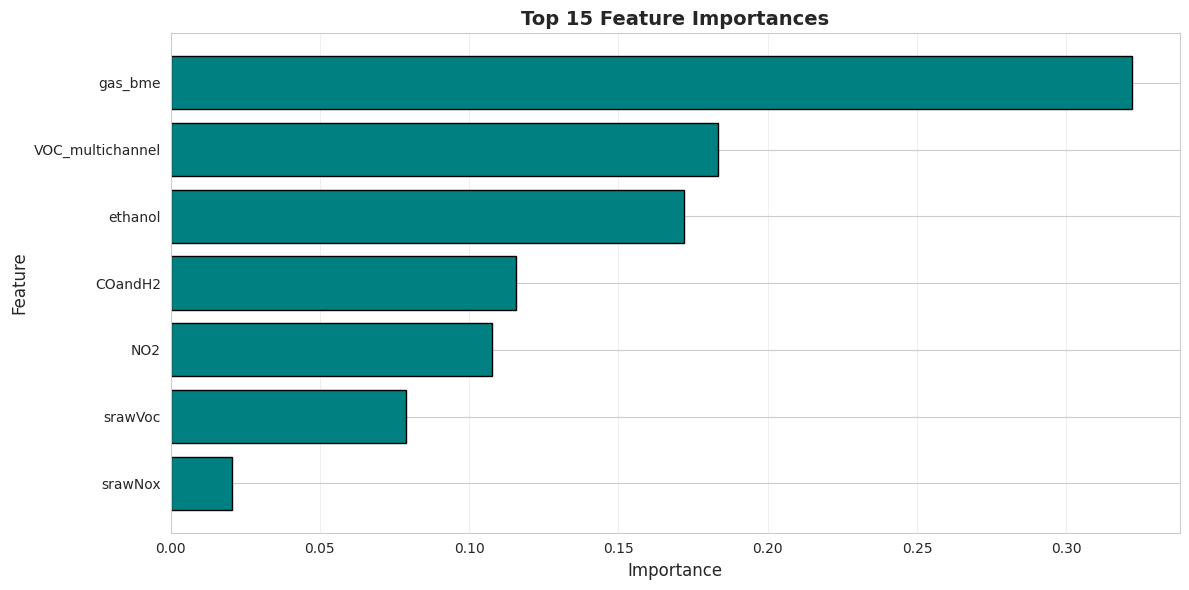

✅ Feature importance analyzed!


In [ ]:
# Feature Importance
feature_importance = pipeline.named_steps['classifier'].feature_importances_

# Get the actual feature names used in training
# The imputer drops columns with all NaN values, so we need to identify which features remain
print(f"📊 Features in trained model: {len(feature_importance)}")
print(f"📊 Features in X_train: {len(X_train.columns)}")

# Find which columns have at least some non-NaN values (these are kept by the imputer)
features_with_data = []
for col in X_train.columns:
    if X_train[col].notna().any():
        features_with_data.append(col)

print(f"📊 Features with data (used in model): {len(features_with_data)}")
print(f"   Features: {features_with_data}")

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features_with_data,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("🔝 Top 10 Most Important Features:")
print("=" * 80)
display(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'].head(15), importance_df['Importance'].head(15), color='teal', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Feature importance analyzed!")

In [ ]:
# Perform 5-fold cross-validation
print("🔄 Performing 5-fold cross-validation...")
print("   This may take a moment...")
print("=" * 80)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print(f"\n📊 Cross-Validation Results:")
print(f"   Fold 1: {cv_scores[0]:.4f}")
print(f"   Fold 2: {cv_scores[1]:.4f}")
print(f"   Fold 3: {cv_scores[2]:.4f}")
print(f"   Fold 4: {cv_scores[3]:.4f}")
print(f"   Fold 5: {cv_scores[4]:.4f}")
print(f"\n   Mean Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"   Min Accuracy: {cv_scores.min():.4f}")
print(f"   Max Accuracy: {cv_scores.max():.4f}")

print("\n✅ Cross-validation completed!")

🔄 Performing 5-fold cross-validation...
   This may take a moment...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Do


📊 Cross-Validation Results:
   Fold 1: 0.9995
   Fold 2: 1.0000
   Fold 3: 0.9995
   Fold 4: 0.9991
   Fold 5: 0.9995

   Mean Accuracy: 0.9995 (±0.0003)
   Min Accuracy: 0.9991
   Max Accuracy: 1.0000

✅ Cross-validation completed!


[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Save the trained pipeline and label encoder
print("💾 Saving model artifacts...")
print("=" * 80)

# Save pipeline
joblib.dump(pipeline, PIPELINE_PATH)
print(f"✅ Pipeline saved to: {PIPELINE_PATH}")

# Save label encoder
joblib.dump(label_encoder, LABEL_ENCODER_PATH)
print(f"✅ Label encoder saved to: {LABEL_ENCODER_PATH}")

# Save model metadata
metadata = {
    'model_type': 'RandomForestClassifier',
    'n_estimators': N_ESTIMATORS,
    'max_depth': MAX_DEPTH,
    'features': feature_cols,
    'target_column': target_col,
    'classes': label_encoder.classes_.tolist(),
    'train_accuracy': float(train_accuracy),
    'test_accuracy': float(test_accuracy),
    'cv_mean_accuracy': float(cv_scores.mean()),
    'cv_std_accuracy': float(cv_scores.std()),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'dataset': DATA_FILE
}

metadata_path = MODEL_DIR / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved to: {metadata_path}")

print("\n🎉 Model training and saving completed successfully!")
print("\n📦 Model Artifacts:")
print(f"   • Pipeline: {PIPELINE_PATH}")
print(f"   • Label Encoder: {LABEL_ENCODER_PATH}")
print(f"   • Metadata: {metadata_path}")

💾 Saving model artifacts...
✅ Pipeline saved to: model/scent_pipeline.joblib
✅ Label encoder saved to: model/label_encoder.joblib
✅ Metadata saved to: model/model_metadata.json

🎉 Model training and saving completed successfully!

📦 Model Artifacts:
   • Pipeline: model/scent_pipeline.joblib
   • Label Encoder: model/label_encoder.joblib
   • Metadata: model/model_metadata.json


In [ ]:
# Test the saved model with a sample prediction
print("🧪 Testing model with sample data...")
print("=" * 80)

# Load saved model
loaded_pipeline = joblib.load(PIPELINE_PATH)
loaded_encoder = joblib.load(LABEL_ENCODER_PATH)

# Get a random sample from test set
sample_idx = np.random.randint(0, len(X_test))
sample_features = X_test.iloc[sample_idx:sample_idx+1]
true_label = loaded_encoder.inverse_transform([y_test[sample_idx]])[0]

# Make prediction
prediction = loaded_pipeline.predict(sample_features)[0]
prediction_proba = loaded_pipeline.predict_proba(sample_features)[0]
predicted_label = loaded_encoder.inverse_transform([prediction])[0]

print(f"📊 Sample Features:")
for col, val in sample_features.iloc[0].items():
    print(f"   {col}: {val}")

print(f"\n🎯 True Label: {true_label}")
print(f"🤖 Predicted Label: {predicted_label}")
print(f"✅ Correct: {'YES ✓' if true_label == predicted_label else 'NO ✗'}")

print(f"\n📈 Prediction Probabilities:")
for i, prob in enumerate(prediction_proba):
    class_name = loaded_encoder.classes_[i]
    bar = '█' * int(prob * 50)
    print(f"   {class_name:20s} {prob:.4f} {bar}")

print("\n✅ Model loaded and tested successfully!")

[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s


🧪 Testing model with sample data...
📊 Sample Features:
   gas_bme: 107.1
   srawVoc: 31011.0
   srawNox: 15068.0
   NO2: 244.0
   ethanol: 236.0
   VOC_multichannel: 278.0
   COandH2: 885.0

🎯 True Label: vanilla
🤖 Predicted Label: vanilla
✅ Correct: YES ✓

📈 Prediction Probabilities:
   cinnamon             0.0000 
   gingerbread          0.0000 
   orange               0.0000 
   vanilla              1.0000 ██████████████████████████████████████████████████

✅ Model loaded and tested successfully!


[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


## 🎉 Summary

### Model Training Complete!

**Key Achievements:**
- ✅ Loaded NATURAL_ML_Data.xlsx dataset
- ✅ Explored and visualized data distributions
- ✅ Preprocessed features (imputation + scaling)
- ✅ Trained Random Forest Classifier
- ✅ Evaluated model performance with cross-validation
- ✅ Saved model artifacts for production use

**Next Steps:**
1. Use `predict_scent.py` script to make predictions from Node.js backend
2. Deploy the model using `serve.py` if needed
3. Monitor model performance with real sensor data
4. Retrain periodically with new data to improve accuracy

**Files Generated:**
- `model/scent_pipeline.joblib` - Complete ML pipeline
- `model/label_encoder.joblib` - Label encoder for scent classes
- `model/model_metadata.json` - Training metadata and performance metrics